## Phase 3 Project
Michal Ostrowski

In [557]:
#Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

The phone comapny XXXXXX has come to us and asked for recommendations that will lower the amount of people leaving their company (churn)  

# Load the data

In [558]:
# Load the dataset
Telecomdf = pd.read_csv("bigml_59c28831336c6604c800002a.csv")

# Data cleaning

In [559]:
# Iterate through the column names
for col in Telecomdf.columns:
    # Check if the column name contains a space
    if " " in col:
        # Replace the space with an underscore
        new_col = col.replace(" ", "_")
        # Rename the column
        Telecomdf = Telecomdf.rename(columns={col: new_col})

In [560]:
#Looking for null values
print(Telecomdf.isnull().sum())

state                     0
account_length            0
area_code                 0
phone_number              0
international_plan        0
voice_mail_plan           0
number_vmail_messages     0
total_day_minutes         0
total_day_calls           0
total_day_charge          0
total_eve_minutes         0
total_eve_calls           0
total_eve_charge          0
total_night_minutes       0
total_night_calls         0
total_night_charge        0
total_intl_minutes        0
total_intl_calls          0
total_intl_charge         0
customer_service_calls    0
churn                     0
dtype: int64


No values appear to be null in the above cell

In [561]:
#Looking for duplicates
print(Telecomdf.duplicated().sum())

0


No duplicates are present

In [562]:
#making alphabetical values numerical
Telecomdf['international_plan'] = np.where(Telecomdf['international_plan'] == 'yes', 1, 0)
Telecomdf['voice_mail_plan'] = np.where(Telecomdf['voice_mail_plan'] == 'yes', 1, 0)

In [563]:
Telecomdf['churn'] = Telecomdf['churn'].astype(str).replace({'True': 1, 'False': 0})

In [564]:
#creating a new column with total charges
Telecomdf = Telecomdf.assign(total_charge=lambda x: x['total_day_charge'] + x['total_eve_charge'] + x['total_night_charge'] + x['total_intl_charge'])

In [565]:
#removing state, they dont seem right as there are many states but only 3 area codes
Telecomdf.drop(columns=['state'], inplace=True)

In [566]:
#removing '-' from phone number, change column to int
Telecomdf['phone_number'] = Telecomdf['phone_number'].replace("-", "", regex=True).astype(int)

# Data Analysis

## OLS Regression

### Total Charges vs Churn

In [567]:
# Define the regression formula
formula = 'churn ~ total_charge'

# Fit the regression model
model = smf.ols(formula, data=Telecomdf).fit()

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  churn   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     188.7
Date:                Fri, 13 Jan 2023   Prob (F-statistic):           8.22e-42
Time:                        15:40:27   Log-Likelihood:                -1157.6
No. Observations:                3333   AIC:                             2319.
Df Residuals:                    3331   BIC:                             2331.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.3165      0.034     -9.280   

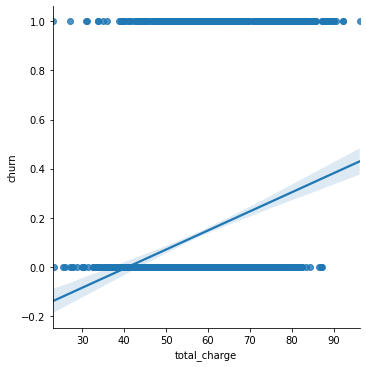

In [568]:
sns.lmplot(x='total_charge', y='churn', data=Telecomdf)

As the total charge goes up, the likliehood of churn increases by a coefficient of .078
With an r-squared value of 0.054, this is not a very good model to explain a higher churn rate.
I recommend to create one single subscription fee. 

# How much can we charge per month?

In [569]:
# Fit a multiple linear regression model
model = smf.ols(formula='total_charge ~ churn', data=Telecomdf).fit()

# Make predictions for a range of churn values
churn_range = pd.DataFrame({'churn': np.linspace(Telecomdf['churn'].min(), Telecomdf['churn'].max(), 100)})
predictions = model.predict(churn_range)

# Find the churn value where the predicted total_charge is minimized
min_index = predictions.idxmin()
min_churn = churn_range.iloc[min_index]['churn']

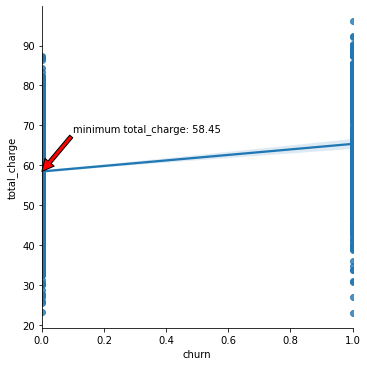

In [570]:
# Create a scatter plot with a multiple linear regression line
sns.lmplot(x='churn', y='total_charge', data=Telecomdf)

# Find the churn value where the predicted total_charge is minimized
min_index = predictions.idxmin()
min_churn = churn_range.iloc[min_index]['churn']

# Annotate the plot with the minimum total_charge and churn values
plt.annotate(f'minimum total_charge: {predictions[min_index]:.2f}', xy=(min_churn, predictions[min_index]), xytext=(min_churn + 0.1, predictions[min_index] + 10), arrowprops={'facecolor': 'red'})

# Label the axes
plt.xlabel('churn')
plt.ylabel('total_charge')

# Show the plot
plt.show()

At this point I see that the point in dollars where people drew the line of when they would cancel their service.  That price was 58.45 dollars.
Seeing this My first recommendation is going to be to create a monthly plan and charge $58.00.


# Comparing churn to account length (time spent with our service)

In [571]:
# create a formula for the regression
formula = 'churn ~ account_length'

# fit the regression to the data
results = smf.ols(formula, data=Telecomdf).fit()

# print a summary of the results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  churn   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9116
Date:                Fri, 13 Jan 2023   Prob (F-statistic):              0.340
Time:                        15:40:33   Log-Likelihood:                -1248.9
No. Observations:                3333   AIC:                             2502.
Df Residuals:                    3331   BIC:                             2514.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.1301      0.017      7.

With an r_squared value of 0, account length has nothing to do with churn rate. However with the previous suggestion of adding some sort of loyalty program, That would add another factor for people who are thinking of switching up their phone provider.

Text(0.5, 1.0, 'The impact of Account Length on Churn')

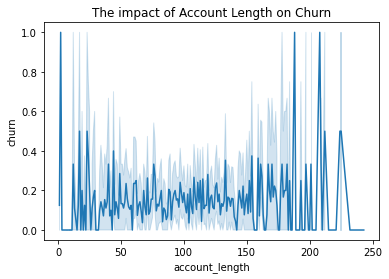

In [572]:
# plot the churn rate on the y-axis and the account length on the x-axis
sns.lineplot(x='account_length', y='churn', data=Telecomdf)
plt.title('The impact of Account Length on Churn')

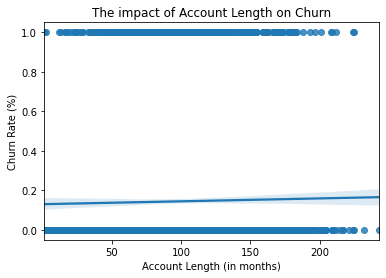

In [573]:
sns.regplot(x='account_length', y='churn', data=Telecomdf)
plt.title('The impact of Account Length on Churn')
plt.xlabel('Account Length (in months)')
plt.ylabel('Churn Rate (%)')
plt.show()

At this point I am seeing that the churn rate gets much higher between 125 and 175 months.  My second suggestion is to offer a loyalty program where your cost goes down close to this point.

# Service calls vs Churn Rate

In [574]:
# create a formula for the regression
formula = 'churn ~ customer_service_calls'

# fit the regression to the data
results = smf.ols(formula, data=Telecomdf).fit()

# print a summary of the results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  churn   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     151.8
Date:                Fri, 13 Jan 2023   Prob (F-statistic):           3.90e-34
Time:                        15:40:42   Log-Likelihood:                -1175.1
No. Observations:                3333   AIC:                             2354.
Df Residuals:                    3331   BIC:                             2367.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

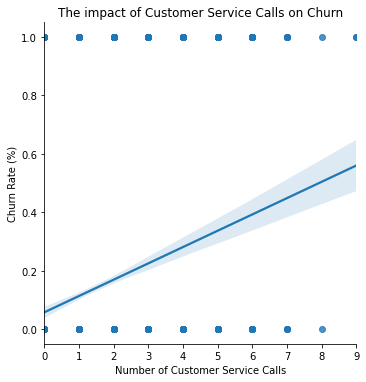

In [575]:
sns.lmplot(x='customer_service_calls', y='churn', data=Telecomdf)
plt.title('The impact of Customer Service Calls on Churn')
plt.xlabel('Number of Customer Service Calls')
plt.ylabel('Churn Rate (%)')
plt.show()

Its clear that customers who suffer from having to call customer service (someone who has a problem) is more likely to leave this company.

Based off this I recommend we do more research into the areas that are more prone to customers calling customer service and look into what is causing these problems.  We need to update/upgrade infastructure possibly?

from these plots above I can see that the more impactful variable to keep churn low would be customer service.

# churn vs international_plan

# Evaluation

In [614]:
# Split the dataset into training and test sets
X = Telecomdf.drop(["churn","account_length", ], axis=1)
y = Telecomdf["churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10000)

# Define the model
model = LogisticRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91       558
           1       0.00      0.00      0.00       109

    accuracy                           0.84       667
   macro avg       0.42      0.50      0.46       667
weighted avg       0.70      0.84      0.76       667



C:\Users\micha\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [595]:
Telecomdf

,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,...,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn,total_charge
0,128,415,3824657,0,1,25,265.1,110,45.07,197.4,...,16.78,244.7,91,11.01,10.0,3,2.70,1,0,75.56
1,107,415,3717191,0,1,26,161.6,123,27.47,195.5,...,16.62,254.4,103,11.45,13.7,3,3.70,1,0,59.24
2,137,415,3581921,0,0,0,243.4,114,41.38,121.2,...,10.30,162.6,104,7.32,12.2,5,3.29,0,0,62.29
3,84,408,3759999,1,0,0,299.4,71,50.90,61.9,...,5.26,196.9,89,8.86,6.6,7,1.78,2,0,66.80
4,75,415,3306626,1,0,0,166.7,113,28.34,148.3,...,12.61,186.9,121,8.41,10.1,3,2.73,3,0,52.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,192,415,4144276,0,1,36,156.2,77,26.55,215.5,...,18.32,279.1,83,12.56,9.9,6,2.67,2,0,60.10
3329,68,415,3703271,0,0,0,231.1,57,39.29,153.4,...,13.04,191.3,123,8.61,9.6,4,2.59,3,0,63.53
3330,28,510,3288230,0,0,0,180.8,109,30.74,288.8,...,24.55,191.9,91,8.64,14.1,6,3.81,2,0,67.74
3331,184,510,3646381,1,0,0,213.8,105,36.35,159.6,...,13.57,139.2,137,6.26,5.0,10,1.35,2,0,57.53
